# Durée passée dans chaque lieu selon la plage horaire

## I - Base de données

In [143]:
''' Importation des packages nécessaires '''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime as dt
import scipy.stats
!pip install openpyxl

In [151]:
emp_df=pd.read_excel("EMP_deplacements.xlsx")
nb_dep_df=emp_df.groupby("IDENT_IND")["num_dep_V"].max().to_frame().rename(columns={"num_dep_V":"nb_dep"})
emp_df=emp_df.set_index("IDENT_IND")
emp_df["nb_dep"]=nb_dep_df["nb_dep"]
emp_df=emp_df.reset_index()
emp_df.head()

,IDENT_IND,POND_JOUR,Motif,Stationnement,Lieu_Depart,Lieu_Arrivee,TYPE_jour,HEURE_DEPART,HEURE_ARRIVEE,INSTANT_DEPART,INSTANT_ARRIVEE,DISTANCE,Segment_detail,Segment,num_dep_V,nb_dep
0,110000011400001,9891.108772,Se rendre dans une grande surface ou un centre...,Emplacement dans un parking public ou commerci...,Domicile,Parking,mercredi,14.25,14.333333,2029-01-03 14:15:00,2029-01-03 14:20:00,2.20000,Particulier,Particulier,1,2
1,110000011400001,9891.108772,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,Domicile,mercredi,14.75,14.833333,2029-01-03 14:45:00,2029-01-03 14:50:00,2.20000,Particulier,Particulier,2,2
2,110000011500001,5275.295948,"Étudier (école, lycée, université)",Emplacement dans un parking public ou commerci...,Domicile,Parking,vendredi,7.75,8.750000,2029-01-05 07:45:00,2029-01-05 08:45:00,28.00000,Particulier,Particulier,1,2
3,110000011500001,5275.295948,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,Domicile,vendredi,10.50,11.000000,2029-01-05 10:30:00,2029-01-05 11:00:00,28.00000,Particulier,Particulier,2,2
4,110000013500002,24058.724023,Travailler dans son lieu fixe et habituel,"Emplacement privé, gratuit (y compris domicile)",Domicile,Entreprise,mercredi,15.00,15.250000,2029-01-03 15:00:00,2029-01-03 15:15:00,5.32141,Particulier,Particulier,1,2


In [152]:
data=emp_df
data["Durée"]=0 #On crée une colonne "durée"
data.loc[data["nb_dep"]==1,"Durée"]=24-data["HEURE_ARRIVEE"]
data.loc[data["nb_dep"]==data["num_dep_V"],"Durée"]=24-data["HEURE_ARRIVEE"]
#On remplit la colonne "durée" en faisant la différence entre l'heure du prochain départ de l'individu et l'heure d'arriver à son lieu actuel.
data.loc[(data["nb_dep"]!=1)&(data["nb_dep"]!=data["num_dep_V"]),'Durée'] = data.groupby('IDENT_IND')["HEURE_DEPART"].shift(-1) - data["HEURE_ARRIVEE"]

/tmp/ipykernel_329/2682466481.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[11.41666667 18.         12.91666667  4.91666667 13.75       14.66666667
 11.5         8.66666667  0.          6.5         1.5         7.33333333
 13.33333333  0.33333333  5.         15.         10.25       11.
 15.          6.5        12.75       15.         16.66666667  7.
 12.25        0.          6.75        9.75        6.83333333  0.
  6.83333333 10.75       14.93333333  8.75        4.5        13.66666667
 17.33333333  5.16666667 15.25       14.5        12.33333333 13.83333333
  2.5         5.          7.83333333  4.83333333 13.          7.5
 16.91666667 17.08333333  5.          9.25        0.25       10.75
 12.25       11.         15.75        7.5         3.5        10.75
  1.5        15.          7.58333333  4.5         7.75        2.5
  0.33333333  4.83333333  5.5        12.83333333  3.         17.
 10.         15.5

### Séparation de la base de données en 4 plages horaires (pour les heures de départ)

In [153]:
emp_df=data
# Matin (départ entre 00h et 11h) :
emp_matin=emp_df[emp_df["HEURE_DEPART"]<=11]
# Midi (départ entre 11h et 14h) :
emp_midi=emp_df[(emp_df["HEURE_DEPART"]>11)&( emp_df["HEURE_DEPART"]<=14)]
# Après-midi (départ entre 14h et 17h) :
emp_am=emp_df[(emp_df["HEURE_DEPART"]>14)&( emp_df["HEURE_DEPART"]<=17)]
# Soir (départ entre 17h et 00h) :
emp_soir=emp_df[(emp_df["HEURE_DEPART"]>17)&( emp_df["HEURE_DEPART"]<=24)]

#### Remarque : Il y a entre 4000 et 7500 déplacements pour chaque plage horaire.

In [147]:
dureenegative=data[data["Durée"]<0].sort_values("IDENT_IND")
dureenegative

,IDENT_IND,POND_JOUR,Motif,Stationnement,Lieu_Depart,Lieu_Arrivee,TYPE_jour,HEURE_DEPART,HEURE_ARRIVEE,INSTANT_DEPART,INSTANT_ARRIVEE,DISTANCE,Segment_detail,Segment,num_dep_V,nb_dep,Durée
16,110000022500001,6792.765286,Retour au domicile,"Stationnement sur la voie publique, gratuit sa...",Parking,Rue,vendredi,17.583333,17.833333,2029-01-05 17:35:00,2029-01-05 17:50:00,7.000000,Particulier,Particulier,2,3,-6.833333
1079,210000074600001,28374.929689,Retour au domicile,"Stationnement sur la voie publique, gratuit, à...",Domicile,Rue,vendredi,16.500000,16.666667,2029-01-05 16:30:00,2029-01-05 16:40:00,4.500000,Particulier,Particulier,4,9,-9.166667
1388,210000184400002,28131.603909,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,Domicile,mardi,16.750000,17.000000,2029-01-02 16:45:00,2029-01-02 17:00:00,3.000000,Particulier,Particulier,1,5,-13.000000
2345,220000172200001,31223.720472,Visite à la famille,"Stationnement sur la voie publique, gratuit sa...",Domicile,Rue,jeudi,18.750000,19.333333,2029-01-04 18:45:00,2029-01-04 19:20:00,40.000000,Particulier,Particulier,1,6,-10.583333
2722,230000065500001,72225.368858,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,Domicile,vendredi,21.250000,21.333333,2029-01-05 21:15:00,2029-01-05 21:20:00,2.500000,Particulier,Particulier,2,6,-11.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20310,910000036200001,17375.573613,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Rue,Domicile,vendredi,16.500000,16.550000,2029-01-05 16:30:00,2029-01-05 16:33:00,0.500000,Particulier,Particulier,2,4,-6.550000
20619,910000166400002,32841.176443,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Entreprise,Domicile,jeudi,18.500000,18.750000,2029-01-04 18:30:00,2029-01-04 18:45:00,7.000000,Particulier,Particulier,2,4,-9.750000
20868,910000334500101,14179.839362,Retour au domicile,"Stationnement sur la voie publique, gratuit sa...",Rue,Rue,lundi,19.166667,19.500000,2029-01-01 19:10:00,2029-01-01 19:30:00,2.000000,Particulier,Particulier,2,5,-6.000000
21769,930000425500001,15731.592451,Retour au domicile,"Stationnement sur la voie publique, gratuit sa...",Parking,Rue,jeudi,16.333333,16.583333,2029-01-04 16:20:00,2029-01-04 16:35:00,10.000000,Particulier,Particulier,2,4,-12.416667


In [154]:
data[data["IDENT_IND"]==930000706500002]

,IDENT_IND,POND_JOUR,Motif,Stationnement,Lieu_Depart,Lieu_Arrivee,TYPE_jour,HEURE_DEPART,HEURE_ARRIVEE,INSTANT_DEPART,INSTANT_ARRIVEE,DISTANCE,Segment_detail,Segment,num_dep_V,nb_dep,Durée
22084,930000706500002,129896.44301,Accompagner quelqu'un à un autre endroit,"Stationnement sur la voie publique, gratuit, à...",Domicile,Rue,samedi,8.50,8.750000,2029-01-06 08:30:00,2029-01-06 08:45:00,10.000000,Particulier,Particulier,1,6,0.750000
22085,930000706500002,129896.44301,"Se rendre dans un centre de proximité, petit c...",Emplacement dans un parking public ou commerci...,Rue,Parking,samedi,9.50,9.833333,2029-01-06 09:30:00,2029-01-06 09:50:00,10.000000,Particulier,Particulier,2,6,0.166667
22086,930000706500002,129896.44301,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,Domicile,samedi,10.00,10.166667,2029-01-06 10:00:00,2029-01-06 10:10:00,5.333333,Particulier,Particulier,3,6,-2.666667
22087,930000706500002,129896.44301,Accompagner quelqu'un à un autre endroit,Pas de stationnement (simple arrêt pour dépose...,Domicile,Sans,samedi,7.50,7.833333,2029-01-06 07:30:00,2029-01-06 07:50:00,13.733333,Particulier,Particulier,1,6,0.016667
22088,930000706500002,129896.44301,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Sans,Domicile,samedi,7.85,8.166667,2029-01-06 07:51:00,2029-01-06 08:10:00,13.046667,Particulier,Particulier,2,6,3.583333
22089,930000706500002,129896.44301,Aller chercher quelqu'un à un autre endroit,Pas de stationnement (simple arrêt pour dépose...,Domicile,Sans,samedi,11.75,12.083333,2029-01-06 11:45:00,2029-01-06 12:05:00,12.800000,Particulier,Particulier,3,6,0.016667
22090,930000706500002,129896.44301,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Sans,Domicile,samedi,12.10,12.500000,2029-01-06 12:06:00,2029-01-06 12:30:00,14.000000,Particulier,Particulier,4,6,1.500000
22091,930000706500002,129896.44301,Se rendre sur un lieu de promenade,"Emplacement privé, gratuit (y compris domicile)",Domicile,Sans,samedi,14.00,14.166667,2029-01-06 14:00:00,2029-01-06 14:10:00,5.333333,Particulier,Particulier,5,6,3.333333
22092,930000706500002,129896.44301,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Sans,Domicile,samedi,17.50,17.666667,2029-01-06 17:30:00,2029-01-06 17:40:00,5.333333,Particulier,Particulier,6,6,6.333333


### Représentation graphique de la durée passée dans chaque lieu pour chaque période de la journée :
    

In [155]:
dist_names = ['norm', 'beta','gamma', 'pareto', 't', 'lognorm', 'invgamma','loggamma', 'invgauss', 'alpha', 'chi', 'chi2']

In [157]:
'''On cherche la loi qui a la plus petite somme des résidus au carré'''
data=emp_matin[emp_matin["Lieu_Arrivee"]==lieu]["Durée"].dropna()
sse = np.inf 
y, x = np.histogram(data, bins=20, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

# Pour chaque distribution
for name in dist_names:

	# Modéliser
	dist = getattr(scipy.stats, name)
	param = dist.fit(data)

	# Paramètres
	loc = param[-2]
	scale = param[-1]
	arg = param[:-2]

	# PDF
	pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
	# SSE
	model_sse = np.sum((y - pdf)**2)

	# Si le SSE est ddiminué, enregistrer la loi
	if model_sse < sse :
		best_pdf = pdf
		sse = model_sse
		best_loc = loc
		best_scale = scale
		best_arg = arg
		best_name = name


/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/mamba/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


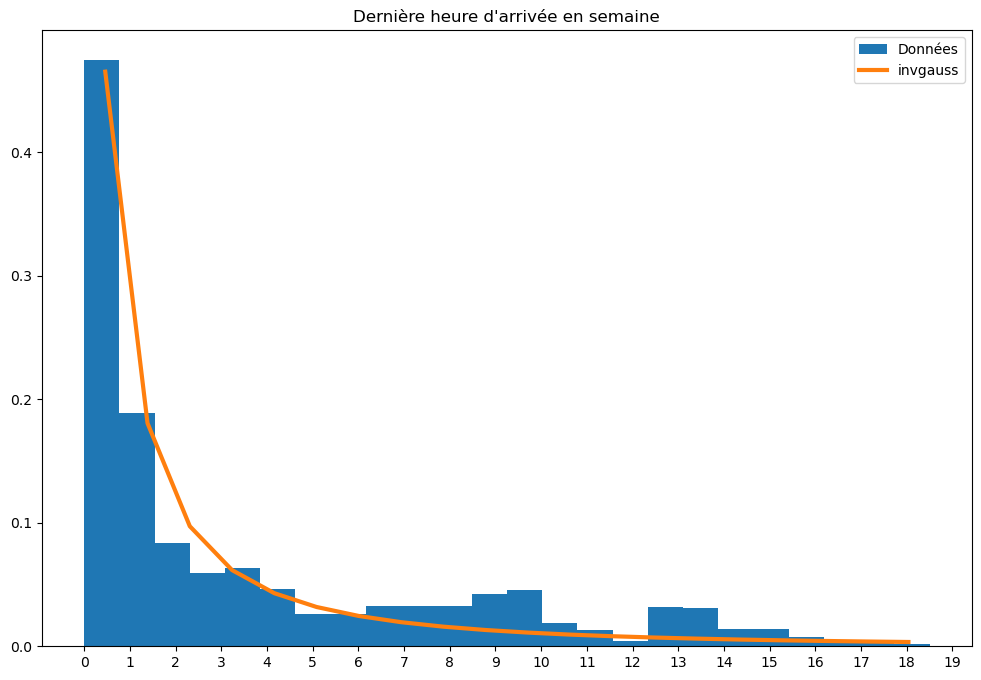

Selected Model :  invgauss
Loc. param. :  -0.1576410362854031
Scale param. :  0.9378377213317148
Other arguments :  (4.090655097132528,)
SSE :  0.006019998298861535


In [158]:
plt.figure(figsize=(12,8))
plt.hist(data,label="Données",bins=24,density=True)
plt.xticks(np.arange(0,24))
plt.plot(x,best_pdf,label=best_name, linewidth=3)
plt.legend(loc='upper right')
plt.title("Dernière heure d'arrivée en semaine")
plt.show()

# Détails sur la loi sélectionnée
print("Selected Model : ", best_name)
print("Loc. param. : ", best_loc)
print("Scale param. : ", best_scale)
print("Other arguments : ", best_arg)
print("SSE : ", sse)

/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/mamba/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:723: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  a, b = optimize.fsolve(func, (1.0, 1

Text(0.5, 0.95, 'Distribution empirique de la durée passée sur chaque lieu le matin')

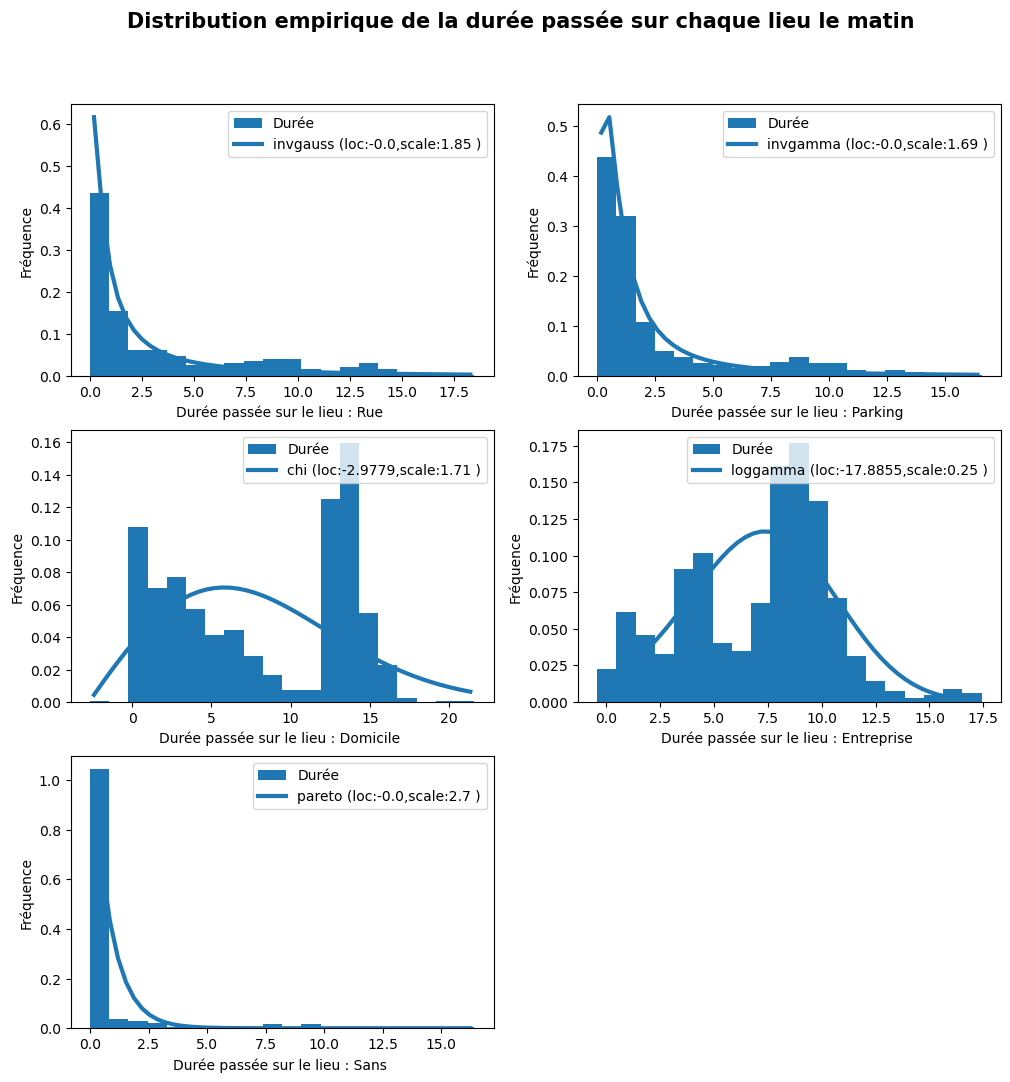

In [176]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))


i=0
j=0
for lieu in list(set(emp_df["Lieu_Arrivee"])):
    emp_matin[emp_matin["Lieu_Arrivee"]==lieu]["Durée"].plot.hist(ax=ax[i][j],bins=20,density=True,ylabel='Fréquence',subplots=True,xlabel="Durée passée sur le lieu : "+lieu+" ")
    '''On cherche la loi qui a la plus petite somme des résidus au carré'''
    data=emp_matin[emp_matin["Lieu_Arrivee"]==lieu]["Durée"].dropna()
    sse = np.inf 
    y, x = np.histogram(data, bins=48, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Pour chaque distribution
    for name in dist_names:

    	# Modéliser
    	dist = getattr(scipy.stats, name)
    	param = dist.fit(data)

    	# Paramètres
    	loc = param[-2]
    	scale = param[-1]
    	arg = param[:-2]

    	# PDF
    	pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
    	# SSE
    	model_sse = np.sum((y - pdf)**2)

    	# Si le SSE est ddiminué, enregistrer la loi
    	if model_sse < sse :
    		best_pdf = pdf
    		sse = model_sse
    		best_loc = loc
    		best_scale = scale
    		best_arg = arg
    		best_name = name
        
    ax[i][j].plot(x,best_pdf,label=best_name+" (loc:"+str(round(loc,4))+",scale:"+str(round(scale,2))+" )", linewidth=3)
    ax[i][j].legend(loc='upper right')
    #ax[i][j].title("Durée passée sur le lieu "+lieu+" le matin :")
    #plt.show()

    if j<1:
        j+=1
    else:
        i+=1
        j=0

ax[2][1].set_axis_off()
fig.suptitle("Distribution empirique de la durée passée sur chaque lieu le matin",va='center', fontweight="bold",fontsize=15,y=0.95)

In [ ]:
emp_matin[emp_matin["Lieu_Arrivee"]==lieu]["Durée"]

In [ ]:
emp_df[emp_df["Durée"].isnull()]

In [135]:
emp_df[emp_df["IDENT_IND"]==930000611500001]

,IDENT_IND,POND_JOUR,Motif,Stationnement,Lieu_Depart,Lieu_Arrivee,TYPE_jour,HEURE_DEPART,HEURE_ARRIVEE,INSTANT_DEPART,INSTANT_ARRIVEE,DISTANCE,Segment_detail,Segment,num_dep_V,nb_dep,Durée
21958,930000611500001,47665.786986,"Se rendre dans un centre de proximité, petit c...","Stationnement sur la voie publique, gratuit sa...",Domicile,Rue,jeudi,8.500000,8.583333,2029-01-04 08:30:00,2029-01-04 08:35:00,2.0,Particulier,Particulier,1,10,0.916667
21959,930000611500001,47665.786986,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Rue,Domicile,jeudi,9.500000,9.583333,2029-01-04 09:30:00,2029-01-04 09:35:00,2.0,Particulier,Particulier,2,10,0.416667
21960,930000611500001,47665.786986,"Se rendre dans un centre de proximité, petit c...",Emplacement dans un parking public ou commerci...,Domicile,Parking,jeudi,10.000000,10.166667,2029-01-04 10:00:00,2029-01-04 10:10:00,2.0,Particulier,Particulier,3,10,0.416667
21961,930000611500001,47665.786986,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,Domicile,jeudi,10.583333,10.750000,2029-01-04 10:35:00,2029-01-04 10:45:00,2.0,Particulier,Particulier,4,10,1.083333
21962,930000611500001,47665.786986,Aller chercher quelqu'un à un autre endroit,Emplacement dans un parking public ou commerci...,Domicile,Parking,jeudi,11.833333,11.916667,2029-01-04 11:50:00,2029-01-04 11:55:00,2.0,Particulier,Particulier,5,10,0.166667
21963,930000611500001,47665.786986,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,Domicile,jeudi,12.083333,12.166667,2029-01-04 12:05:00,2029-01-04 12:10:00,2.0,Particulier,Particulier,6,10,1.833333
21964,930000611500001,47665.786986,"Se rendre dans un centre de proximité, petit c...",Emplacement dans un parking public ou commerci...,Domicile,Parking,jeudi,14.000000,14.083333,2029-01-04 14:00:00,2029-01-04 14:05:00,2.0,Particulier,Particulier,7,10,0.250000
21965,930000611500001,47665.786986,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,Domicile,jeudi,14.333333,14.500000,2029-01-04 14:20:00,2029-01-04 14:30:00,2.0,Particulier,Particulier,8,10,1.500000
21966,930000611500001,47665.786986,"Se rendre dans un centre de proximité, petit c...",Emplacement dans un parking public ou commerci...,Domicile,Parking,jeudi,16.000000,16.166667,2029-01-04 16:00:00,2029-01-04 16:10:00,2.0,Particulier,Particulier,9,10,0.666667
21967,930000611500001,47665.786986,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,Domicile,jeudi,16.833333,17.000000,2029-01-04 16:50:00,2029-01-04 17:00:00,2.0,Particulier,Particulier,10,10,7.000000


/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/mamba/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6471: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718: RuntimeWarnin

Text(0.5, 0.95, 'Distribution empirique de la durée passée sur chaque lieu le midi')

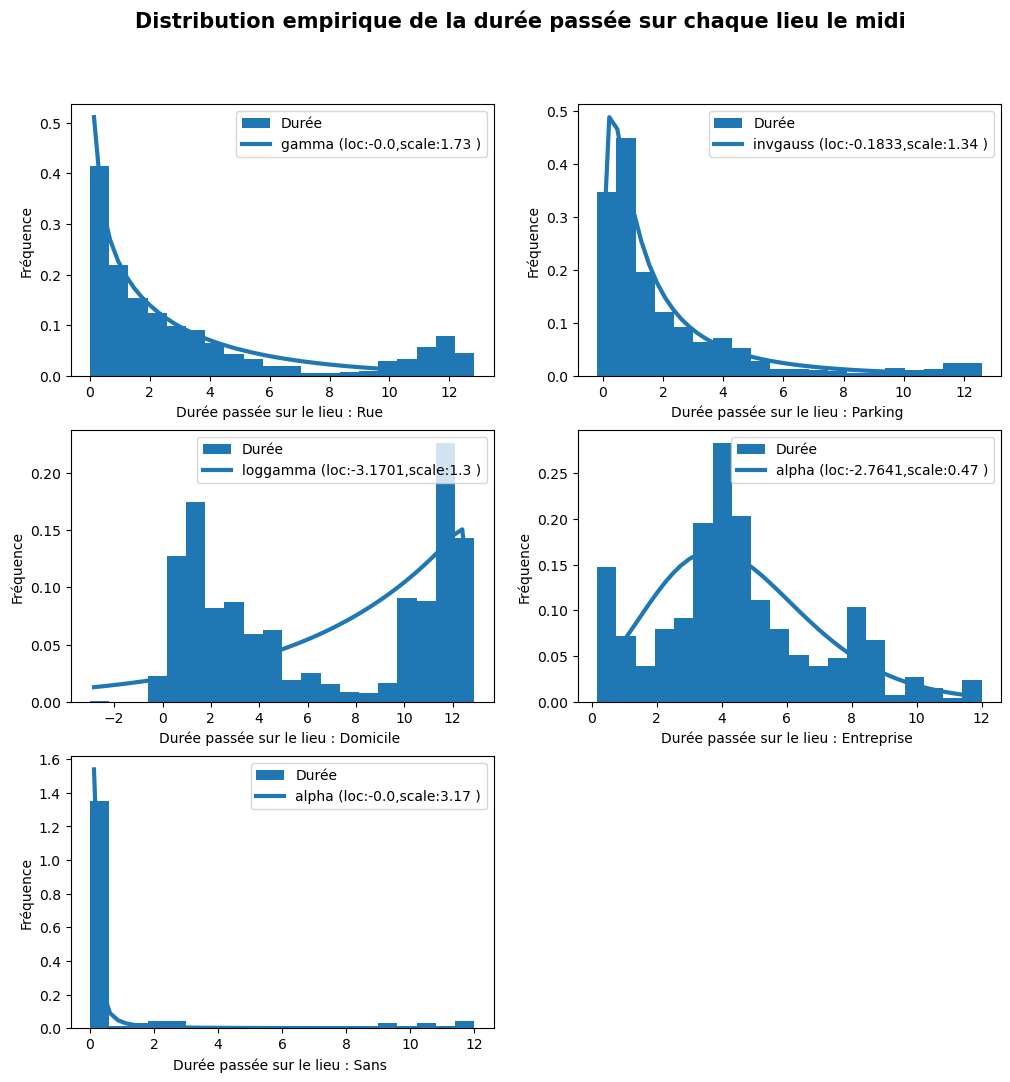

In [178]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
i=0
j=0
for lieu in list(set(emp_df["Lieu_Arrivee"])):
    emp_midi[emp_midi["Lieu_Arrivee"]==lieu]["Durée"].plot.hist(ax=ax[i][j],bins=20,density=True,ylabel='Fréquence',subplots=True,xlabel="Durée passée sur le lieu : "+lieu+" ")
    '''On cherche la loi qui a la plus petite somme des résidus au carré'''
    data=emp_midi[emp_midi["Lieu_Arrivee"]==lieu]["Durée"].dropna()
    sse = np.inf 
    y, x = np.histogram(data, bins=48, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Pour chaque distribution
    for name in dist_names:

    	# Modéliser
    	dist = getattr(scipy.stats, name)
    	param = dist.fit(data)

    	# Paramètres
    	loc = param[-2]
    	scale = param[-1]
    	arg = param[:-2]

    	# PDF
    	pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
    	# SSE
    	model_sse = np.sum((y - pdf)**2)

    	# Si le SSE est ddiminué, enregistrer la loi
    	if model_sse < sse :
    		best_pdf = pdf
    		sse = model_sse
    		best_loc = loc
    		best_scale = scale
    		best_arg = arg
    		best_name = name
        
    ax[i][j].plot(x,best_pdf,label=best_name+" (loc:"+str(round(loc,4))+",scale:"+str(round(scale,2))+" )", linewidth=3)
    ax[i][j].legend(loc='upper right')
    #ax[i][j].title("Durée passée sur le lieu "+lieu+" le matin :")
    #plt.show()

    if j<1:
        j+=1
    else:
        i+=1
        j=0
ax[2][1].set_axis_off()
fig.suptitle("Distribution empirique de la durée passée sur chaque lieu le midi",va='center', fontweight="bold",fontsize=15,y=0.95)

/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6471: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:723: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6471: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_

Text(0.5, 0.95, "Distribution empirique de la durée passée sur chaque lieu l'après-midi")

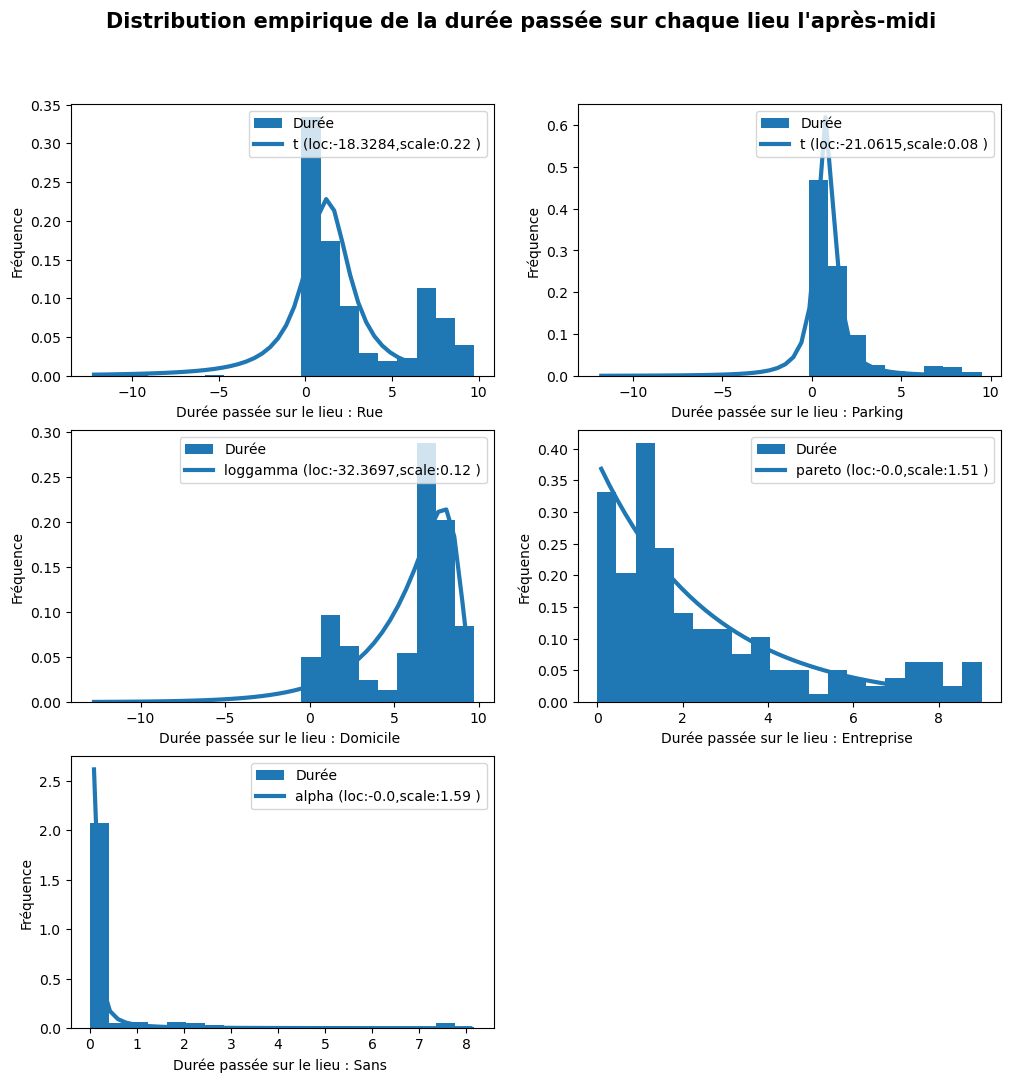

In [179]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
i=0
j=0
for lieu in list(set(emp_df["Lieu_Arrivee"])):
    emp_am[emp_am["Lieu_Arrivee"]==lieu]["Durée"].plot.hist(ax=ax[i][j],bins=20,density=True,ylabel='Fréquence',subplots=True,xlabel="Durée passée sur le lieu : "+lieu+" ")
    '''On cherche la loi qui a la plus petite somme des résidus au carré'''
    data=emp_am[emp_am["Lieu_Arrivee"]==lieu]["Durée"].dropna()
    sse = np.inf 
    y, x = np.histogram(data, bins=48, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Pour chaque distribution
    for name in dist_names:

    	# Modéliser
    	dist = getattr(scipy.stats, name)
    	param = dist.fit(data)

    	# Paramètres
    	loc = param[-2]
    	scale = param[-1]
    	arg = param[:-2]

    	# PDF
    	pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
    	# SSE
    	model_sse = np.sum((y - pdf)**2)

    	# Si le SSE est ddiminué, enregistrer la loi
    	if model_sse < sse :
    		best_pdf = pdf
    		sse = model_sse
    		best_loc = loc
    		best_scale = scale
    		best_arg = arg
    		best_name = name
        
    ax[i][j].plot(x,best_pdf,label=best_name+" (loc:"+str(round(loc,4))+",scale:"+str(round(scale,2))+" )", linewidth=3)
    ax[i][j].legend(loc='upper right')
    #ax[i][j].title("Durée passée sur le lieu "+lieu+" le matin :")
    #plt.show()

    if j<1:
        j+=1
    else:
        i+=1
        j=0

ax[2][1].set_axis_off()
fig.suptitle("Distribution empirique de la durée passée sur chaque lieu l'après-midi",va='center', fontweight="bold",fontsize=15,y=0.95)

/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:723: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6471: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:723: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = o

Text(0.5, 0.95, 'Distribution empirique de la durée passée sur chaque lieu le soir')

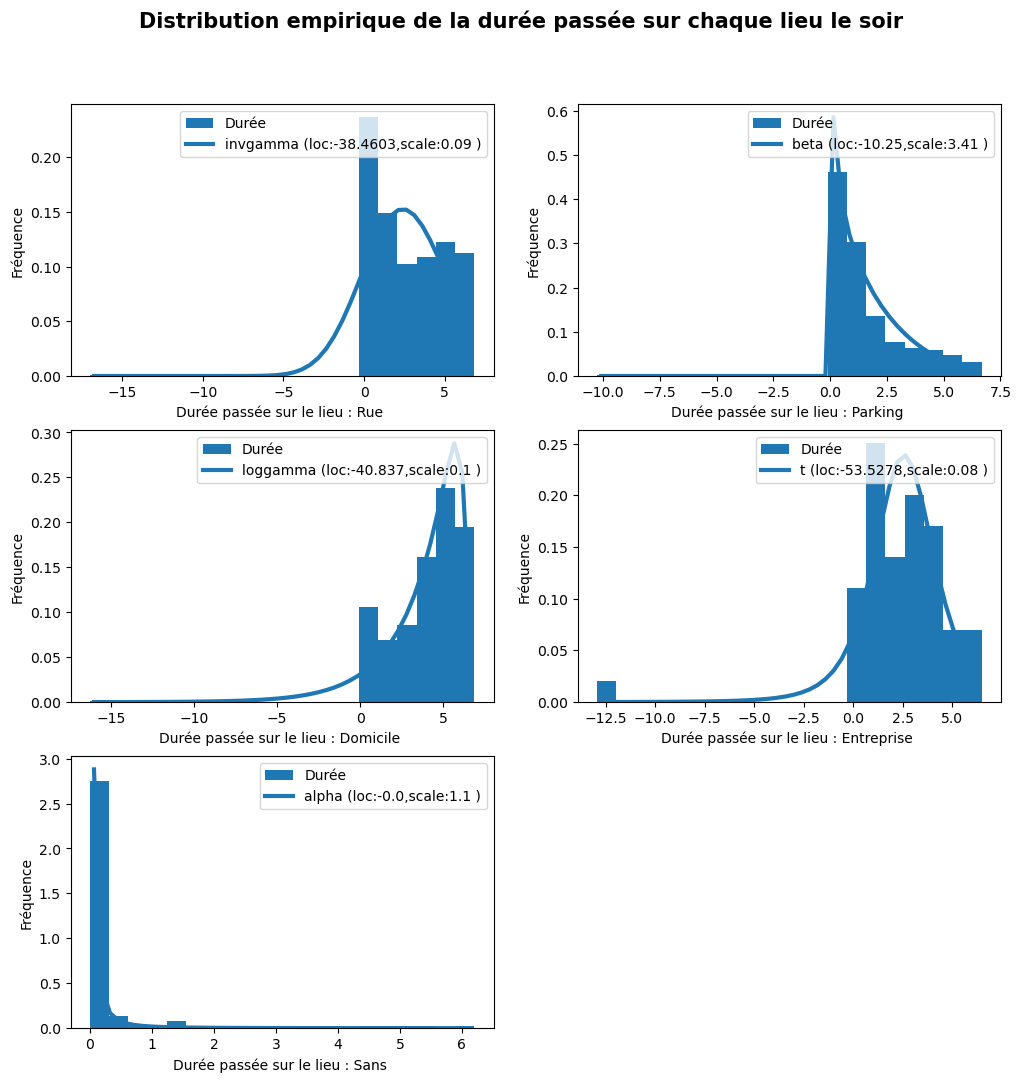

In [180]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
i=0
j=0
for lieu in list(set(emp_df["Lieu_Arrivee"])):
    emp_soir[emp_soir["Lieu_Arrivee"]==lieu]["Durée"].plot.hist(ax=ax[i][j],bins=20,density=True,ylabel='Fréquence',subplots=True,xlabel="Durée passée sur le lieu : "+lieu+" ")
    '''On cherche la loi qui a la plus petite somme des résidus au carré'''
    data=emp_soir[emp_soir["Lieu_Arrivee"]==lieu]["Durée"].dropna()
    sse = np.inf 
    y, x = np.histogram(data, bins=48, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Pour chaque distribution
    for name in dist_names:

    	# Modéliser
    	dist = getattr(scipy.stats, name)
    	param = dist.fit(data)

    	# Paramètres
    	loc = param[-2]
    	scale = param[-1]
    	arg = param[:-2]

    	# PDF
    	pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
    	# SSE
    	model_sse = np.sum((y - pdf)**2)

    	# Si le SSE est ddiminué, enregistrer la loi
    	if model_sse < sse :
    		best_pdf = pdf
    		sse = model_sse
    		best_loc = loc
    		best_scale = scale
    		best_arg = arg
    		best_name = name
        
    ax[i][j].plot(x,best_pdf,label=best_name+" (loc:"+str(round(loc,4))+",scale:"+str(round(scale,2))+" )", linewidth=3)
    ax[i][j].legend(loc='upper right')
    #ax[i][j].title("Durée passée sur le lieu "+lieu+" le matin :")
    #plt.show()

    if j<1:
        j+=1
    else:
        i+=1
        j=0

ax[2][1].set_axis_off()
fig.suptitle("Distribution empirique de la durée passée sur chaque lieu le soir",va='center', fontweight="bold",fontsize=15,y=0.95)